In [1]:
import os
import glob
import random
import numpy as np
import imageio.v2 as imageio
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import vgg16_bn, VGG16_BN_Weights

# Utils

In [2]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device used: ", device)

Device used:  cuda


In [3]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s ' % checkpoint_path)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

label2color = [
    [  0, 255, 255], # 0: (Cyan: 011) Urban land
    [255, 255,   0], # 1: (Yellow: 110) Agriculture land
    [255,   0, 255], # 2: (Purple: 101) Rangeland
    [  0, 255,   0], # 3: (Green: 010) Forest land
    [  0,   0, 255], # 4: (Blue: 001) Water
    [255, 255, 255], # 5: (White: 111) Barren land
    [  0,   0,   0], # 6: (Black: 000) Unknown
]

In [5]:
def mean_iou_score(pred, labels):
    """ Compute mean IoU score over 6 classes """
    mean_iou = 0.0
    for i in range(6):
        tp_fp = np.sum(pred == i)
        tp_fn = np.sum(labels == i)
        tp = np.sum((pred == i) * (labels == i))
        iou = tp / (tp_fp + tp_fn - tp)
        mean_iou += iou / 6
        print('class #%d : %1.5f'%(i, iou))
    print('\nmean_iou: %f\n' % mean_iou)

    return mean_iou

# Visualization

In [6]:
def satelliteshow(satellite):
    """ Show satellite image """
    # unnormalize
    for t, m, s in zip(satellite, mean, std):
        t.mul_(s).add_(m)
    plt.imshow(np.transpose(satellite, (1, 2, 0)))
    plt.show()

def maskshow(mask):
    """ Show mask image """
    plt.imshow(np.transpose(mask, (1, 2, 0)))
    plt.show()

def labelshow(label):
    """ Show label image """
    label = torch.squeeze(label).cpu().numpy()
    labelimg = [[label2color[int(label[j][i])] for i in range(label.shape[0])] for j in range(label.shape[0])]
    plt.imshow(labelimg)
    plt.show()

# Custom Dataset & DataLoader

In [7]:
class HW1P2(Dataset):
    def __init__(self, dirpath, transform=None, is_train=False):
        """ Initialize custom dataset """
        self.filepaths = []
        self.is_train = is_train

        self.transform_satellite = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
        self.transform_label = transforms.Compose([
            transforms.ToTensor(),
        ])

        # get all image names
        for fp in glob.glob(dirpath + '/*_sat.jpg'):
            self.filepaths.append(fp[0:fp.find('_sat.jpg')])
    
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        fp = self.filepaths[index]
        fn = os.path.basename(fp)
        satellite = Image.open(fp + '_sat.jpg')
        mask = Image.open(fp + '_mask.png')

        # data augmentation
        if self.is_train:
            satellite, label = self.randomimg(satellite, mask)
        else:
            label = mask

        # satellite
        if self.transform_satellite is not None:
            satellite = self.transform_satellite(satellite)
        
        # label
        # label = transforms.functional.resize(label, (512, 512))
        label = self.maskimg2labelimg(np.array(label))
        if self.transform_label is not None:
            label = self.transform_label(label)

        # mask
        mask = self.maskimg2labelimg(np.array(mask))
        if self.transform_label is not None:
            mask = self.transform_label(mask)
        
        return fn, satellite, label, mask
    
    def __len__(self):
        """ Get total number of samples in the dataset """
        return len(self.filepaths)
    
    def maskimg2labelimg(self, mask):
        """ Transfer mask image (3x512x512) into label image (1x512x512) """
        mask = (mask >= 128).astype(int)
        mask = 4 * mask[:, :, 0] + 2 * mask[:, :, 1] + mask[:, :, 2]
        label = mask.copy()
        label[mask == 3] = 0  # (Cyan: 011) Urban land
        label[mask == 6] = 1  # (Yellow: 110) Agriculture land
        label[mask == 5] = 2  # (Purple: 101) Rangeland
        label[mask == 2] = 3  # (Green: 010) Forest land
        label[mask == 1] = 4  # (Blue: 001) Water
        label[mask == 7] = 5  # (White: 111) Barren land
        label[mask == 0] = 6  # (Black: 000) Unknown

        return label
    
    def randomimg(self, satellite, label):
        """ Data augmentation """
        # random horizontal flip
        if random.random() > 0.5:
            satellite = transforms.functional_pil.hflip(satellite)
            label = transforms.functional_pil.hflip(label)
        # random vertical flip
        if random.random() > 0.5:
            satellite = transforms.functional_pil.vflip(satellite)
            label = transforms.functional_pil.vflip(label)
        # random rotate
        if random.random() > 0.1:
            angle = random.randint(0, 360)
            satellite = transforms.functional_pil.rotate(satellite, angle)
            label = transforms.functional_pil.rotate(label, angle)
        # random crop
        # rect = transforms.RandomCrop(224).get_params(satellite, (224, 224))
        # satellite = transforms.functional_pil.crop(satellite, rect[0], rect[1], rect[2], rect[3])
        # label = transforms.functional_pil.crop(label, rect[0], rect[1], rect[2], rect[3])
        satellite = transforms.functional.resize(satellite, (224, 224))
        return satellite, label

In [8]:
trainset = HW1P2(dirpath="./hw1_data/p2_data/train", is_train=True)
trainset_origin = HW1P2(dirpath="./hw1_data/p2_data/train", is_train=False)
testset = HW1P2(dirpath="./hw1_data/p2_data/validation", is_train=False)

In [9]:
dataloader = {
    'train': DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4),
    'train_origin': DataLoader(trainset_origin, batch_size=64, shuffle=False, num_workers=4),
    'validation': DataLoader(testset, batch_size=64, shuffle=False, num_workers=4),
}

In [10]:
dataiter = iter(dataloader['validation'])
fns, satellites, labels, masks = dataiter.next()
print('Image tensor in each batch:', satellites.shape, satellites.dtype)
print('Image tensor in each batch:', labels.shape, labels.dtype)
print('Image tensor in each batch:', masks.shape, masks.dtype)

Image tensor in each batch: torch.Size([64, 3, 224, 224]) torch.float32
Image tensor in each batch: torch.Size([64, 1, 512, 512]) torch.int64
Image tensor in each batch: torch.Size([64, 1, 512, 512]) torch.int64


0 1811


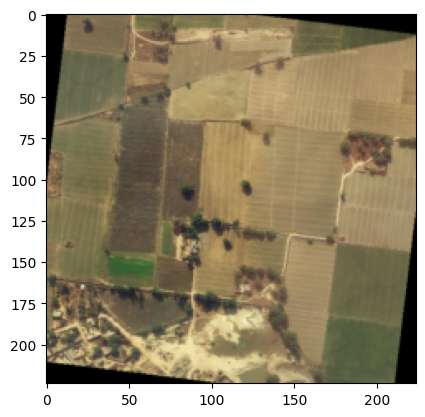

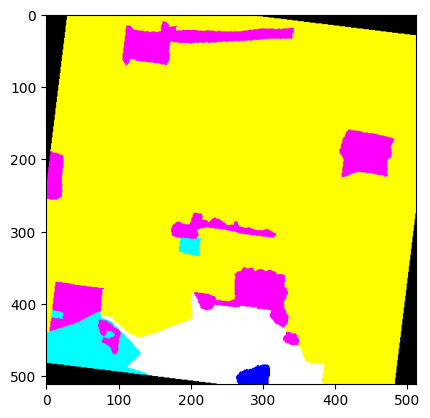

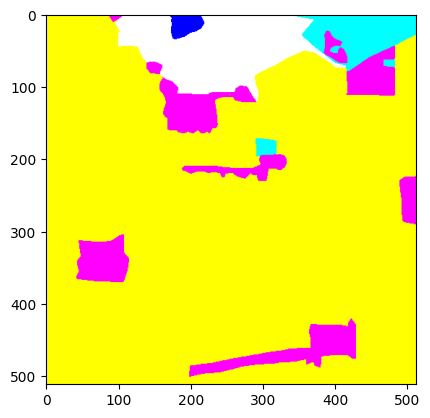

In [11]:
for i in range(1):
    index = 0
    # index = random.randint(0, len(trainset))
    fn, satellite, label, mask = dataloader['train'].dataset[index]
    print(index, fn)
    satelliteshow(satellite)
    labelshow(label)
    labelshow(mask)

# Semantic Segmentation Model

In [12]:
class VGG16FCN32(nn.Module):
    def __init__(self, vgg16_weights=None, num_classes=7):
        super(VGG16FCN32, self).__init__()
        # 3 x 224 x 224
        self.feats = vgg16(weights=vgg16_weights).features
        # 512 x 7 x 7
        self.fcn32 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # 512 x 7 x 7
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # 512 x 7 x 7
            nn.ReLU(),
            nn.Dropout(),
            # upsampling
            nn.ConvTranspose2d(512, 7, kernel_size=4, stride=4, padding=0), # 7 x 28 x 28
            nn.Upsample(size=(512,512), mode='bilinear'), # 7 x 512 x 512
        )

    def forward(self, x):
        feats = self.feats(x)
        fcn32 = self.fcn32(feats)
        return fcn32

In [13]:
class VGG16FCN8(nn.Module):
    def __init__(self, vgg16_weights=None, num_classes=7):
        super(VGG16FCN8, self).__init__()
        feat = list(vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features.children())
        self.pool3 = nn.Sequential(*feat[  :17]) # 256 x 28 x 28
        self.pool4 = nn.Sequential(*feat[17:24]) # 512 x 14 x 14
        self.pool5 = nn.Sequential(*feat[24:  ]) # 512 x 7 x 7
        self.convo = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # 4096 x 1 x 1
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # 4096 x 1 x 1
            nn.ReLU(),
            nn.Dropout(),
            nn.ConvTranspose2d(512, 256, kernel_size=6, stride=4, padding=1), # 256 x 28 x 28
        )
        self.pool4upsample = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0), # 256 x 28 x 28
        )
        self.allupsample = nn.Sequential(
            nn.ConvTranspose2d(256, 7, kernel_size=8, stride=8, padding=0), # 7 x 224 x 224 
            # 
            nn.Upsample(size=(512,512), mode='bilinear'), # 7 x 512 x 512
        )

    def forward(self, x):
        p3 = self.pool3(x)
        p4 = self.pool4(p3)
        p5 = self.pool5(p4)

        p4up = self.pool4upsample(p4)
        conv = self.convo(p5)

        fcn8 = self.allupsample(p3 + p4up + conv)
        
        return fcn8

# Train & Test

In [14]:
def train(model, optimizer, criterion, dataloader, epochs=5, log_interval=100, init_epoch=0):
    model.train()

    best_mIoU = -1

    for epoch in range(epochs):
        running_loss = 0
        for batch_idx, (fns, x, y, true_y) in enumerate(dataloader['train']):
            x = x.to(device)
            temp_y = y
            y = y.type(torch.LongTensor).to(device)
            y = torch.squeeze(y, 1)
            
            optimizer.zero_grad()
            y_out = model(x)
            pred = y_out.max(1, keepdim=True)[1]

            loss = criterion(y_out, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step() 

        running_loss /= len(dataloader['train'].dataset)
        print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, 
            running_loss,
        ))
        
        # mIoU = test(model, criterion, dataloader['train_origin'])
        mIoU = test(model, criterion, dataloader['validation'])

        print('best_mIoU = ', best_mIoU, '\tmIoU = ', mIoU, '\n')
        if mIoU > best_mIoU:
            best_mIoU = mIoU
            save_checkpoint('./checkpoint/temp/best-hw1p2A-%i.pth' % (init_epoch), model, optimizer)
        
        if epoch % 10 == 0:
            save_checkpoint('./checkpoint/temp/hw1p2A-%i.pth' % (epoch + init_epoch), model, optimizer)
    save_checkpoint('./checkpoint/temp/hw1p2A-%i.pth' % (epochs + init_epoch), model, optimizer)
    print('Best mIoU = ', best_mIoU)

In [15]:
def test(model, criterion, dataloader):
    model.eval()
    
    total_loss = 0
    predarray = []
    yarray = []
    with torch.no_grad():
        for fns, x, y, true_y in dataloader:
            x = x.to(device)
            true_y = true_y.type(torch.LongTensor).to(device)
            true_y = torch.squeeze(true_y, 1).to(device)
            
            y_out = model(x)
            pred = y_out.max(1, keepdim=True)[1]
            total_loss += criterion(y_out, true_y).item()

            predarray.extend(pred.cpu().numpy().flatten())
            yarray.extend(true_y.cpu().numpy().flatten())
        
    total_loss /= len(dataloader.dataset)

    mIoU = mean_iou_score(np.array(predarray), np.array(yarray))

    print('Average loss: {:.4f}\n'.format(
        total_loss, 
    ))
    return mIoU

### Model A : VGG16FCN32

In [16]:
vgg16fcn32 = VGG16FCN32(
    vgg16_weights=VGG16_Weights.IMAGENET1K_V1,
    num_classes=7,
)
vgg16fcn32.to(device)
optimizer = optim.Adam(vgg16fcn32.parameters(), lr=0.0002, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
print(vgg16fcn32)

VGG16FCN32(
  (feats): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [18]:
# train(vgg16fcn32, optimizer, criterion, dataloader, epochs=50)

Train Epoch: 0 	Loss: 0.021387
class #0 : 0.02467
class #1 : 0.73680
class #2 : 0.00000
class #3 : 0.40062
class #4 : 0.00000
class #5 : 0.00017

mean_iou: 0.193710

Average loss: 0.0160

best_mIoU =  -1 	mIoU =  0.19370978708749834 

model saved to ./checkpoint/temp/best-hw1p2A-0.pth
model saved to ./checkpoint/temp/hw1p2A-0.pth
Train Epoch: 1 	Loss: 0.012447
class #0 : 0.60069
class #1 : 0.77902
class #2 : 0.00138
class #3 : 0.72512
class #4 : 0.60400
class #5 : 0.31500

mean_iou: 0.504201

Average loss: 0.0112

best_mIoU =  0.19370978708749834 	mIoU =  0.5042007047242187 

model saved to ./checkpoint/temp/best-hw1p2A-0.pth
Train Epoch: 2 	Loss: 0.009511
class #0 : 0.63558
class #1 : 0.83835
class #2 : 0.02998
class #3 : 0.65840
class #4 : 0.57165
class #5 : 0.58499

mean_iou: 0.553159

Average loss: 0.0094

best_mIoU =  0.5042007047242187 	mIoU =  0.5531591449160831 

model saved to ./checkpoint/temp/best-hw1p2A-0.pth
Train Epoch: 3 	Loss: 0.008675
class #0 : 0.65515
class #1 : 0.84

### Model B : VGG16FCN8

In [19]:
vgg16fcn8 = VGG16FCN8(
    vgg16_weights=VGG16_Weights.IMAGENET1K_V1,
    num_classes=7,
)
vgg16fcn8.to(device)
optimizer = optim.Adam(vgg16fcn8.parameters(), lr=0.0002, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
print(vgg16fcn8)

VGG16FCN8(
  (pool3): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [20]:
# train(vgg16fcn8, optimizer, criterion, dataloader, epochs=200)

# Inference

### Model A : VGG16FCN32

In [21]:
new_model = VGG16FCN32(num_classes=7)
new_model.to(device)
optimizer = optim.Adam(new_model.parameters(), lr=0.0002, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [22]:
load_checkpoint('./checkpoint/hw1p2A/best-hw1p2A-0.pth', new_model, optimizer)
mIoU = test(new_model, criterion, dataloader['validation'])

model loaded from ./checkpoint/hw1p2A/best-hw1p2A-0.pth 
class #0 : 0.73199
class #1 : 0.88839
class #2 : 0.37572
class #3 : 0.79303
class #4 : 0.73959
class #5 : 0.70920

mean_iou: 0.706319

Average loss: 0.0058



In [23]:
for i in range(0, 51, 10):
    load_checkpoint('./checkpoint/hw1p2A/hw1p2A-%i.pth' % i, new_model, optimizer)
    mIoU = test(new_model, criterion, dataloader['validation'])

model loaded from ./checkpoint/hw1p2A/hw1p2A-0.pth 
class #0 : 0.02467
class #1 : 0.73680
class #2 : 0.00000
class #3 : 0.40062
class #4 : 0.00000
class #5 : 0.00017

mean_iou: 0.193710

Average loss: 0.0160

model loaded from ./checkpoint/hw1p2A/hw1p2A-10.pth 
class #0 : 0.70239
class #1 : 0.84852
class #2 : 0.15017
class #3 : 0.68798
class #4 : 0.63889
class #5 : 0.66217

mean_iou: 0.615021

Average loss: 0.0074

model loaded from ./checkpoint/hw1p2A/hw1p2A-20.pth 
class #0 : 0.72740
class #1 : 0.87493
class #2 : 0.28408
class #3 : 0.79586
class #4 : 0.71574
class #5 : 0.69020

mean_iou: 0.681369

Average loss: 0.0062

model loaded from ./checkpoint/hw1p2A/hw1p2A-30.pth 
class #0 : 0.73490
class #1 : 0.87933
class #2 : 0.25504
class #3 : 0.80847
class #4 : 0.72129
class #5 : 0.67640

mean_iou: 0.679237

Average loss: 0.0061

model loaded from ./checkpoint/hw1p2A/hw1p2A-40.pth 
class #0 : 0.73687
class #1 : 0.88174
class #2 : 0.34338
class #3 : 0.77519
class #4 : 0.70297
class #5 : 0.

### Model B : VGG16FCN8

In [24]:
new_model = VGG16FCN8(num_classes=7)
new_model.to(device)
optimizer = optim.Adam(new_model.parameters(), lr=0.0002, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [25]:
load_checkpoint('./checkpoint/hw1p2B/best-hw1p2B-50.pth', new_model, optimizer)
mIoU = test(new_model, criterion, dataloader['validation'])

model loaded from ./checkpoint/hw1p2B/best-hw1p2B-50.pth 
class #0 : 0.76444
class #1 : 0.89563
class #2 : 0.45892
class #3 : 0.80901
class #4 : 0.76431
class #5 : 0.73841

mean_iou: 0.738451

Average loss: 0.0065



In [26]:
for i in range(0, 201, 10):
    load_checkpoint('./checkpoint/hw1p2B/hw1p2B-%i.pth' % i, new_model, optimizer)
    mIoU = test(new_model, criterion, dataloader['validation'])

model loaded from ./checkpoint/hw1p2B/hw1p2B-0.pth 
class #0 : 0.05582
class #1 : 0.64937
class #2 : 0.00559
class #3 : 0.14132
class #4 : 0.00252
class #5 : 0.01086

mean_iou: 0.144246

Average loss: 0.0189

model loaded from ./checkpoint/hw1p2B/hw1p2B-10.pth 
class #0 : 0.71339
class #1 : 0.84705
class #2 : 0.09586
class #3 : 0.77536
class #4 : 0.67863
class #5 : 0.61901

mean_iou: 0.621549

Average loss: 0.0077

model loaded from ./checkpoint/hw1p2B/hw1p2B-20.pth 
class #0 : 0.72322
class #1 : 0.87055
class #2 : 0.29974
class #3 : 0.77691
class #4 : 0.68153
class #5 : 0.63900

mean_iou: 0.665160

Average loss: 0.0064

model loaded from ./checkpoint/hw1p2B/hw1p2B-30.pth 
class #0 : 0.75305
class #1 : 0.88176
class #2 : 0.29858
class #3 : 0.80510
class #4 : 0.69594
class #5 : 0.70966

mean_iou: 0.690681

Average loss: 0.0056

model loaded from ./checkpoint/hw1p2B/hw1p2B-40.pth 
class #0 : 0.75476
class #1 : 0.88601
class #2 : 0.35650
class #3 : 0.81017
class #4 : 0.72638
class #5 : 0.